In [16]:
print("Select a house type:\n a: All \n b: Detached  \n c: Semi Detached \n d: Terraced  \n e: Flats and Maisonettes \n  ")
typeQuery=input()
typeQuery="1"+typeQuery

Select a house type:
 a: All 
 b: Detached  
 c: Semi Detached 
 d: Terraced  
 e: Flats and Maisonettes 
  


Read data

In [15]:
import pandas as pd
import xlrd
import numpy as np
filePath = "Houseprices2.xls"
prices = pd.read_excel(filePath, sheet_name=typeQuery)
names = pd.read_csv("MsoaNames.csv", usecols=["MSOA21CD", "MSOA21NM", "WD23NM"])

def convertToYearMonth(colName):
    parts = colName.split(' ')
    month = parts[2]
    year = parts[3]

    monthNumber = pd.to_datetime(month, format='%b').month
    formattedDate = f"{year}-{monthNumber:02d}"
    return formattedDate
newColumnNames = {col: convertToYearMonth(col) for col in prices.columns[4:114]  }
prices.rename(columns=newColumnNames, inplace=True)

In [17]:
print("Enter an area")
areaQuery=input()
code=names.loc[names["WD23NM"]==areaQuery]["MSOA21CD"].reset_index(drop=True)
if code.empty:
    print ("Area does not exist")
areaPrices=prices[prices["MSOA code"].isin(code)].T
areaPrices.columns=areaPrices.iloc[3]
areaPrices=areaPrices[4:]
msoaLen=len(areaPrices.columns)
areaPrices = areaPrices.apply(pd.to_numeric, errors='coerce').dropna(how="all")
areaPrices["Average"]=areaPrices.mean(axis=1)
timeSeries=areaPrices["Average"].diff().dropna()*0.0001


Enter an area


Plots

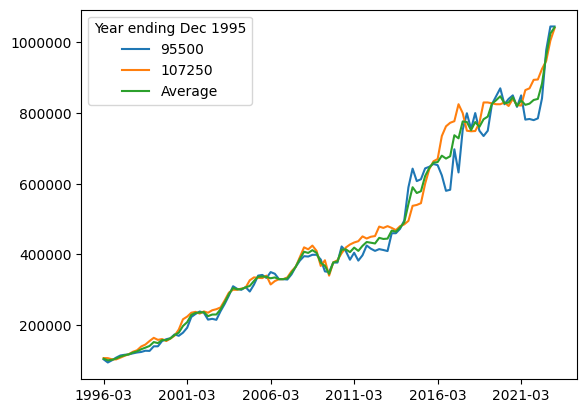

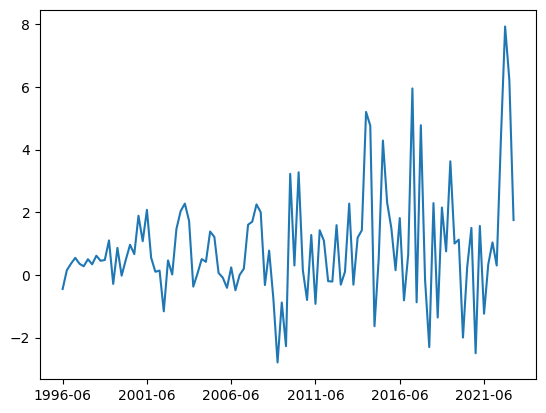

In [18]:
import matplotlib.pyplot as plt
areaPrices.plot()
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.ScalarFormatter(useMathText=False))
ax.yaxis.get_major_formatter().set_scientific(False)


plt.show()
timeSeries.plot()
plt.show()

fitting a arima garch

In [19]:
import pmdarima
import arch
arimaModel = pmdarima.auto_arima(timeSeries)
p, d, q = arimaModel.order
arimaResiduals = arimaModel.arima_res_.resid
garch = arch.arch_model(arimaResiduals, p=1, q=1)
garchFitted = garch.fit(disp="off")
predictedMu=arimaModel.predict(n_periods=10)
garchForecast=garchFitted.forecast(horizon=10)
predictedEpsilon=garchForecast.mean.iloc[0,:]
prediction=[]
for i in range(10):
    prediction.append((predictedMu.iloc[i]+predictedEpsilon.iloc[i])*10000)
print(predictedMu)
print(prediction)


2023-06-01    1.032995
2023-09-01    0.898361
2023-12-01    0.873080
2024-03-01    0.868333
2024-06-01    0.867442
2024-09-01    0.867274
2024-12-01    0.867243
2025-03-01    0.867237
2025-06-01    0.867236
2025-09-01    0.867236
Freq: QS-DEC, dtype: float64
[8258.929353629701, 6912.586497307697, 6659.779490855947, 6612.309129045071, 6603.395470827748, 6601.721725362486, 6601.407440944778, 6601.348426777293, 6601.337345502601, 6601.335264737015]


Year ending Dec 1995         95500        107250       Average
1996-03               1.030000e+05  1.067500e+05  1.048750e+05
1996-06               9.425000e+04  1.065000e+05  1.003750e+05
1996-09               1.005000e+05  1.032500e+05  1.018750e+05
1996-12               1.080000e+05  1.030000e+05  1.055000e+05
1997-03               1.140000e+05  1.078750e+05  1.109375e+05
...                            ...           ...           ...
2024-09               1.084149e+06  1.084149e+06  1.084149e+06
2024-12               1.090750e+06  1.090750e+06  1.090750e+06
2025-03               1.097351e+06  1.097351e+06  1.097351e+06
2025-06               1.103953e+06  1.103953e+06  1.103953e+06
2025-09               1.110554e+06  1.110554e+06  1.110554e+06

[119 rows x 3 columns]


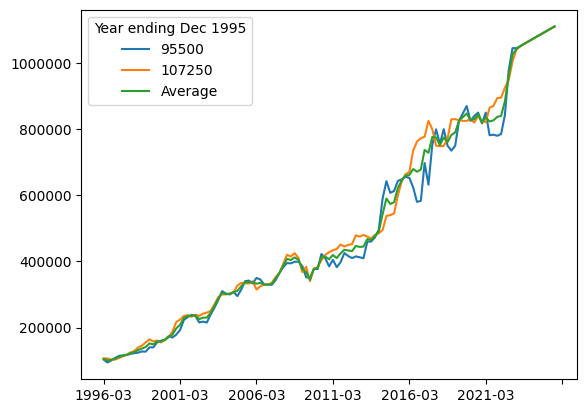

In [21]:
date_str="2023-03"
for i in range(10):
    tmonth = 6 + 3*i
    tyear = 2023 + (tmonth - 1) // 12
    tmonth = (tmonth - 1) % 12 + 1  
    
    predictionRow=([prediction[i]+areaPrices["Average"][date_str]]*(msoaLen+1))
    date_str = f"{tyear}-{tmonth:02}"
    areaPrices.loc[date_str]=predictionRow
print(areaPrices)
areaPrices.plot()

ax = plt.gca()

ax.yaxis.set_major_formatter(plt.ScalarFormatter(useMathText=False))
ax.yaxis.get_major_formatter().set_scientific(False)
plt.show()

Importing crime data:

In [ ]:
crime=pd.read_csv("Crime10-22.csv", usecols=lambda x: x != "Minor Text" or "WardCode" or "LookUp_BoroughName")
currentCrime=pd.read_csv("Crime22-24.csv", usecols=lambda x: x != "Minor Text" or "WardCode" or "LookUp_BoroughName")

